### **SECTION 1: SANITATION DATA**


This section describes the process of loading, processing and transformation of the available raw data into the shape and form suitable for clustering algorithms.

### SECTION 1.1: UPLOAD OF DATA TO GOOGLE COLAB

The data collected consists of 244 rows (points), each of which has 7 columns (features). The 7 features are:

1. Timestamp
2. GPS coordinates
3. Type of infrastructure component/features of interest
4. Rate the sanitary state of the identified feature
5. What is the main source of drinking water in the area?	
6. Are water treatment methods observed in the area?
7. If yes, what water treatment method is used? If no, why?

The first step in the analysis of the data was to upload a file called **sanitation_data.csv** from a local computer to Google Colab using Colab's library as show below (commented out because data had been uploaded to Google Colab at the time of writing this report):



In [1623]:
########## LEAVE THIS COMMENTED BECAUSE THE FILE HAS BEEN UPLOADED ##########
%reset -f
!pip install wget
import wget
url_sanitation_data = "https://raw.githubusercontent.com/ruslanmasinjila/CHOLERA-HYPER-SURVEILLANCE/master/data/sanitation_data.csv"
url_elevations_json_data = "https://raw.githubusercontent.com/ruslanmasinjila/CHOLERA-HYPER-SURVEILLANCE/master/data/elevations_data.json"
#from google.colab import files
sanitation_data = wget.download(url_sanitation_data)
elevations_json_data = wget.download(url_elevations_json_data)

### SECTION 1.2: PANDAS DATAFRAME

The data from **sanitation_data.csv** was read and converted to Pandas Data Frame using the Pandas library as shown below:

In [1624]:
import pandas as pd
sanitation_data = pd.read_csv("sanitation_data.csv")

# shuffle the DataFrame rows
# sanitation_data = sanitation_data.sample(frac = 1)

sanitation_data["Type of infrastructure component/features of interest"] = sanitation_data["Type of infrastructure component/features of interest"].replace(['municipal water ','County  council ', 'County water'],'Community water point')
sanitation_data["Type of infrastructure component/features of interest"] = sanitation_data["Type of infrastructure component/features of interest"].replace(['Garbage','Gabbage','Garvage'],'Solid waste site')
sanitation_data["Type of infrastructure component/features of interest"] = sanitation_data["Type of infrastructure component/features of interest"].replace(['Borehole','Tap water', 'Rain water'],'Other infrastructures')
#print(sanitation_data["Type of infrastructure component/features of interest"].value_counts())

sanitation_data["What is the main source of drinking water in the area?"] = sanitation_data["What is the main source of drinking water in the area?"].replace(['Borhole','Borehole ', 'Borohol','borehole','Bowhole','Bohole','Borehole water', 'Piped and borehole','Bore hole','Borehol','Tap water/ borehole water'],'Borehole')
sanitation_data["What is the main source of drinking water in the area?"] = sanitation_data["What is the main source of drinking water in the area?"].replace(['Bottle water','Bottled water ','bottled','Bottlled water','Bottled and tap water '],'Bottled water')
sanitation_data["What is the main source of drinking water in the area?"] = sanitation_data["What is the main source of drinking water in the area?"].replace(['River','river','Rever'],'River water')
sanitation_data["What is the main source of drinking water in the area?"] = sanitation_data["What is the main source of drinking water in the area?"].replace(['Running tap water','tap water ','tap water','Tap','Tap water ','Tap from olerai ','Running tap'],'Tap water')
sanitation_data["What is the main source of drinking water in the area?"] = sanitation_data["What is the main source of drinking water in the area?"].replace(['Community water point','Tap water from community water centre','Tap/kanjo ','Citycouncil water','Community water tank ','community water point','Community water tank','Kanjo water '],'Community water point')
sanitation_data["What is the main source of drinking water in the area?"] = sanitation_data["What is the main source of drinking water in the area?"].replace(['Stotage tank','Storage tank','storage tanks','Storage water tank','Water tank'],'Water storage tank')
sanitation_data["What is the main source of drinking water in the area?"] = sanitation_data["What is the main source of drinking water in the area?"].replace(['rain water','Rain water/ tap water','Rain water/tapwater', 'Rain water', 'run off', 'run off water', 'Run off water'], 'Other Sources')
sanitation_data["What is the main source of drinking water in the area?"] = sanitation_data["What is the main source of drinking water in the area?"].replace(['Water vendor','refill water','Refill','water refill points','donkey cart','Water refil'],'Water refill')
sanitation_data["What is the main source of drinking water in the area?"] = sanitation_data["What is the main source of drinking water in the area?"].replace(['piped water','Piped','piped'],'Water pipe')
sanitation_data["What is the main source of drinking water in the area?"] = sanitation_data["What is the main source of drinking water in the area?"].replace(['Non','Non '],'None')
#print(sanitation_data["What is the main source of drinking water in the area?"].value_counts())

sanitation_data["If yes, what water treatment method is used? If no, why?"] = sanitation_data["If yes, what water treatment method is used? If no, why?"].replace(['Crolin','chlorine and water guard','Whater gurd','Watergaurd','Water guard','chlorinated and purified','Chlorine treated ','Chlorine','Chlorine treatment ','Chrorin','chlorine','chlorination','Chlorinating','Chlorinated'],'Chlorination')
sanitation_data["If yes, what water treatment method is used? If no, why?"] = sanitation_data["If yes, what water treatment method is used? If no, why?"].replace(['Not sure if treated','Not sure','Not sure which one','The vendor is unaware','Not aware','lack of awareness','Unaware','lack of knowledge','they dont care','Lack of awareness','They have no idea','lack of knowlegde on water treatment methods','ignorance', 'Ignorance'],'Ignorance / Unawareness')
sanitation_data["If yes, what water treatment method is used? If no, why?"] = sanitation_data["If yes, what water treatment method is used? If no, why?"].replace(['Boiling and watergaurd','chlorine and boiling.','Chlorination, boiling','boiling','Boiling water','boiling/chlorination'],'Boiling')
sanitation_data["If yes, what water treatment method is used? If no, why?"] = sanitation_data["If yes, what water treatment method is used? If no, why?"].replace(['They buy mostly bottled drinking water ','Bought water','People buy bottled water','The area uses bottled bought drinking water, then we have no treatment methods around the area.'],'Bottled water')
sanitation_data["If yes, what water treatment method is used? If no, why?"] = sanitation_data["If yes, what water treatment method is used? If no, why?"].replace(['Lack of proper chemicals','expense',"They can't afford it",'Too expensive'],'Expensive')
sanitation_data["If yes, what water treatment method is used? If no, why?"] = sanitation_data["If yes, what water treatment method is used? If no, why?"].replace(['Government county council ','Council ','Not sure says its from the city council','Treated well','Treated from the water source','City council treated '],'City council')
sanitation_data["If yes, what water treatment method is used? If no, why?"] = sanitation_data["If yes, what water treatment method is used? If no, why?"].replace(['None observed ','None observed','No water point observed','Cleaned tanks','None','Reservation','None obsevered ','Watertank','There are none','Water tank','No tanks','Running dirty water','Water ','already treated','No storage facility ','No storage tanks','Its borehole water','They drink directly from tap','No treatment plant ','None ','Direct from the tap.  ','There’s no area with such facility or sale of treatment ','We haven’t identified any treatment method around','Floating sewarage water'],'None / Unclear response')
sanitation_data["If yes, what water treatment method is used? If no, why?"] = sanitation_data["If yes, what water treatment method is used? If no, why?"].replace(['purification and filtration','purification and filtration.','filtration','Water dispenser','Purification','Decantation'],'Other methods (Purification, Filtration, Decantation, Water dispenser)')
#print(sanitation_data["If yes, what water treatment method is used? If no, why?"].value_counts())

### SECTION 1.3: REMOVAL OF TIMESTAMP COLUMN

The first column of the **sanitation_data** dataframe obtained in SECTION 1.2 contained **Timestamp** column which was removed as follows:

In [1625]:
sanitation_data = sanitation_data.drop(["Timestamp"],axis=1)

### SECTION 1.4: DECOUPLING OF GPS COORDINATES

The **GPS Coordinates** column of the sanitation data was in the form of a string **"latitude, longitude"**. This form of representation was decoupled into separate numerical **latitude** and **longitude** columns as follows:

In [1626]:
temp= sanitation_data[['GPS coordinates']]
lat_long_sanitation=pd.DataFrame()
lat_long_sanitation[['latitude','longitude']] = temp['GPS coordinates'].str.split(',',expand=True).astype(float)

### SECTION 1.5: DREMOVAL OF GPS COORDINATES COLUMN
The **GPS Coordinates** column was then removed from the dataframe as follows:

In [1627]:
sanitation_data = sanitation_data.drop(['GPS coordinates'], axis=1)
#print(sanitation_data.head())

At this point, there are two Pandas dataframes.

The **sanitation_data** with the following columns:

1. Type of infrastructure component/features of interest
2. Rate the sanitary state of the identified feature
3. What is the main source of drinking water in the area?
4. Are water treatment methods observed in the area?
5. If yes, what water treatment method is used? If no, why?

The **lat_long_sanitation** with the following columns:

1. latitude
2. longitude

### SECTION 1.6: INSERTION OF ELEVATION COLUMN INTO lat_long_sanitation

The **GPS Coordinates** column described in SECTION 1.4 resulted into only two separate numerical columns for latitudes and longitudes. A third column, called **elevation**, which contained heights at the corresponding longitudes and latitudes was added with the help of [Google's Point Elevation API](https://developers.google.com/maps/documentation/elevation/overview). The API simply returns a json file with the heights for each latitude-longitude pair. This file was renamed to **elevations_data.json**. The following code shows how this API can be used.

In [1628]:
temp=lat_long_sanitation.to_csv(header=None, index=False).split('\n')
lat_long_API = '|'.join([str(elem) for elem in temp]) 
lat_long_API = lat_long_API[0:-1]
#print(lat_long_API)
#https://maps.googleapis.com/maps/api/elevation/json?locations=lat_long_API&key=YOUR_API_KEY

The file **elevations_data.json** was uploaded to Google Colab in SECTION 1.1 along with **sanitation_data.csv**

All the elevations from **elevations_data.json** were loaded into **elevations** list as follows:

In [1629]:
import json

with open('elevations_data.json') as f:
  elevations_data = json.load(f)

elevations = []

for i in elevations_data["results"]:
  elevations.append(i.get("elevation"))

The elevations of the **elevations** list were joined with the latitudes and longitudes of the **lat_long_sanitation** dataframe to form **lat_long_ele_sanitation** dataframe as follows:

In [1630]:
lat_long_ele_sanitation = lat_long_sanitation
lat_long_ele_sanitation["elevation"] = elevations

### SECTION 1.7: TRANSFORMATION OF LATITUDES, LONGITUDES, AND ELEVATIONS INTO X, Y,  Z COORDINATES

By this point, there are three Pandas dataframes. 

The **sanitation_data** with the following columns:
1. Type of infrastructure component/features of interest
2. Rate the sanitary state of the identified feature
3. What is the main source of drinking water in the area?
4. Are water treatment methods observed in the area?
5. If yes, what water treatment method is used? If no, why?


The **lat_long_sanitation** with the following columns:
1. latitude
2. longitude

and the **lat_long_elev_sanitation** with the following columns:
1. latitude
2. longitude
3. elevation


Since the latitudes, longitudes, and elevations are angular measurements, they can't be linearly scalled to produce meaningul results in clustering algorithms such as **K-means**, which is one of the clustering algorithms to be covered in SECTION 2.

### SECTION 1.7.1: GEODETIC TO ECEF CONVERSION

One of the common ways of converting latitudes ($\phi$), longitudes ($\lambda$), and elevation ($h$) from their polar form to their linear/cartesian form (X,Y,Z) is called Geodetic to ECEF (acronym for earth-centered, earth-fixed) conversion.

In this conversion, we have:

$X = (N(\phi)+h)cos(\phi)cos(\lambda)$

$Y = (N(\phi)+h)cos(\phi)sin(\lambda)$

$Z = \left(\frac{b²}{a²}N(\phi)+h \right)sin(\phi)$

Where:

$N(\phi)=\frac{a}{\sqrt{1-e^{2}sin^2\phi}}$ and $e^{2}=1-\frac{b^2}{a^2}$

and

$a=6378137.0 m$

$b=6356752.314245 m m$

The following code implements the above set of equations to transform the polar coordinates in **lat_long_ele_sanitation** dataframe to their linear/cartesian equivalent in the **X_Y_Z** dataframe.

In [1631]:
import math


a=6378137.0
b=6356752.314245
e_squared=1-(b**2)/(a**2)

# Latitude (deg), Longitude (deg), Elevation (meters)
def geodetic_to_ecef(latitude,longitude,elevation):
    
    lamb = math.radians(latitude)
    phi = math.radians(longitude)
    h=elevation



    Nphi=a/math.sqrt(1-e_squared*(math.sin(lamb))**2)

    sin_lambda = math.sin(lamb)
    cos_lambda = math.cos(lamb)
    sin_phi = math.sin(phi)
    cos_phi = math.cos(phi)

    X = (Nphi+h) * cos_lambda * cos_phi
    Y = (Nphi+h) * cos_lambda * sin_phi
    Z = (((1 - e_squared) * Nphi)+h)* sin_lambda

    return X,Y,Z

X_Y_Z=lat_long_ele_sanitation.apply(lambda row:geodetic_to_ecef(row["latitude"],row["longitude"],row["elevation"]), axis=1)

# Convert the series to Pandas DataFrame
X_Y_Z = X_Y_Z.to_frame()
X_Y_Z = pd.DataFrame(X_Y_Z[0].to_list(), columns=['X','Y','Z'])


#print(X_Y_Z)
#print(sanitation_data)

### SECTION 1.7.2: COMBINING TRANSFORMED COORDINATES WITH REST OF DATA

The following code shows the joining of **X_Y_Z** dataframe to **sanitation_data** dataframe to form the **xyz_sanitation_data** dataframe that has the basic form for clustering in SECTION 2.

In [1632]:
x_y_z_sanitation_data = pd.DataFrame()
x_y_z_sanitation_data = pd.concat([X_Y_Z,sanitation_data], axis=1)
#print(x_y_z_sanitation_data)

======================================================================================================================================================================================================================================

# SECTION 2: DATA CLUSTERING
This section aims to leverage on some of the popular clustering algorithms available today to determine if there is any relationship between the different variables of the sanitation data provided. This section will also take a look at possible spacial distribution of different data points.

### SECTION 2.1: GOWER'S SIMILARITY MATRIX 

Since the transformed data, **xyz_sanitation_data** (SECTION 1.7.2), contains both numerical and categorical information, it may not be apparent which of the variables are similar, or disimilar. **Gower's matrix** computes the similarities/disimilarities of mixed variables (numerical and categorical) in data by calculating all the pair-wise distances between every data point within the data.
Gower's similarity matrix can therefore be applied to **xyz_sanitation_data** dataframe since X, Y, Z and the "Rate the sanitary state" are numerical, while the rest of the variables are categorical.

A 0 distance means the variable(s) are 100% similar (distance to itself), and a 1 means the variables are 100% disimilar (the opposite).

In other words, the closer the Gower's score is close to 0, the higher the similarity between the variables, and therefore, these variables are more likely to be grouped or clustered together.



### SECTION 2.1.1: APPLICATION OF GOWER'S MATRIX ON SANITATION DATA

This section will take a look at potential application of the Gower's Similarity Matrix on the data provided.
The code below installs and imports gower and other libraries.

In [1633]:
####################################################################
print("********************************************")
!pip install gower
print("********************************************")
import gower
import numpy as np
####################################################################

********************************************
********************************************


A single line of code using the gower library on the **sanitation_data** dataframe is all that is needed to produce a 244x244 square matrix (since there are 244 data points as mentioned in SECTION 1.1). The leading diagonal of the reulting square matrix are all 0s (because the data point calculates distance to itself). Below is the code:

In [1634]:
####################################################################
similarity_matrix=gower.gower_matrix(sanitation_data)
print(similarity_matrix)
####################################################################

[[0.         0.03333334 0.73333335 ... 0.6        0.43333334 0.33333334]
 [0.03333334 0.         0.76666665 ... 0.6333333  0.46666667 0.36666667]
 [0.73333335 0.76666665 0.         ... 0.93333334 0.9        0.4       ]
 ...
 [0.6        0.6333333  0.93333334 ... 0.         0.43333334 0.93333334]
 [0.43333334 0.46666667 0.9        ... 0.43333334 0.         0.7       ]
 [0.33333334 0.36666667 0.4        ... 0.93333334 0.7        0.        ]]


The 244 data points in the dataset can be ranked relative to each other according to their Gower scores in the above matrix. The lower the score from each other, the higher the similarity between datapoints. 

For example, the following function ranks the indices of the data points according to their Gower scores, starting from lowest to highest, relative to the $ith$ datapoint. The function also returns the actual scores (distances) of the data points from the $ith$ data point.

In this example, the $ith$ data point is the 25th data point (24th row of the dataframe) of the sanitation_data dataframe. For this example, only data points that are within the Gower score [0, 0.1] from the $25th$ data point are selected.

In [1635]:
####################################################################
import numpy as np


def calculateGowers(i=24):
    
    # Ignore scores above this threshold. 
    # This threshold can be changed
    # The lower the threshold, the similar the data points
    gower_score_threshold = 0.1

    # Compute the Gower Score for Row i
    gower_scores_i = similarity_matrix[i,:]

    # Sort the Gower Scores and return their corresponding indices
    idx_i_sorted = np.argsort(gower_scores_i)

    # Get the Gower scores according to the sorted indices
    gower_scores_i_sorted = similarity_matrix[i,[idx_i_sorted]][0]
    gower_scores_i_sorted = [x for x in gower_scores_i_sorted if x <= gower_score_threshold]

    # Get the corresponding sorted indices given by the threshold
    idx_i_sorted = idx_i_sorted[0:len(gower_scores_i_sorted)]


    print("********************************************")
    print("If i is a data point at",i,"then the indices and Gower scores of the points closest to",i, "are as follows:")
    print("********************************************")
    print("Sorted Indices:",idx_i_sorted)
    print("Sorted Gower Scores:",gower_scores_i_sorted)

    return idx_i_sorted, gower_scores_i_sorted
    ####################################################################

idx_i_sorted, gower_scores_i_sorted = calculateGowers( )

********************************************
If i is a data point at 24 then the indices and Gower scores of the points closest to 24 are as follows:
********************************************
Sorted Indices: [ 25  24 235  19  28  21  20  88 142  87  86 138 139 140  83 141]
Sorted Gower Scores: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335]


The following code displays a histogram of the Gower scores in the above example such that the left-most scores represent the most similar data points, and the right-most scores represent the most dissimilar data points.

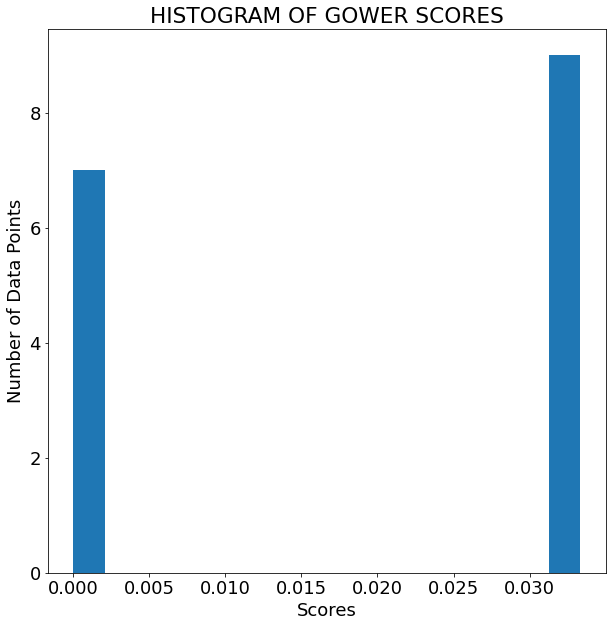

In [1636]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})
plt.hist(gower_scores_i_sorted, bins=len(gower_scores_i_sorted))
plt.title('HISTOGRAM OF GOWER SCORES')
plt.xlabel('Scores')
plt.ylabel('Number of Data Points')
plt.show()

The next code shows similar data points in **sanitation_data** which are similar to the first entry (data at row 0)

In [1637]:
print("*************************************")
for i in idx_i_sorted:
  print("coordinates:",np.asarray(lat_long_sanitation.loc[[i],["latitude","longitude"]])[0])
  print(sanitation_data.loc[i,:])
  print("*************************************")

*************************************
coordinates: [-1.3979124 36.7665209]
Type of infrastructure component/features of interest       Run off water/sewer line
Rate the sanitary state of the identified feature                                  4
What is the main source of drinking water in the area?                      Borehole
Are water treatment methods observed in the area?                                YES
If yes, what water treatment method is used? If no, why?                Chlorination
Name: 25, dtype: object
*************************************
coordinates: [-1.3979124 36.7665209]
Type of infrastructure component/features of interest       Run off water/sewer line
Rate the sanitary state of the identified feature                                  4
What is the main source of drinking water in the area?                      Borehole
Are water treatment methods observed in the area?                                YES
If yes, what water treatment method is used? If no, why?     

From the above output, and using Gower's similary scores, we can conclude that

A) There are 15 datapoints similar to the datapoint at index 24 of the given data at a threshold of 0.1.

B) The sanitary levels at these 15 similar datapoints are 4 and 5, people prefer to use Borehole water in these areas and observe water treament through Chlorination. The features of interest are Run off water/sewer line.

The example above is for data points that are close to the 25th data point in the dataframe within the Grower threshold of 0.1. 

The similarity between the rest of the data points can be determined in a similar fashion through the specification of the row index and the threshold. The code below asks the user the specifiy a data point by its index and outputs similar data points at the threshold of 0.1

======================================================================================================================================================================================================================================

### SECTION 2.1.2: RELATION BETWEEN SANITATION RATES AND OTHER VARIABLES

This section will take a look at the following cases:

CASE1: SANITARY STATE VS TYPE OF INFRASTRUCTURE OF INTEREST

CASE2: SANITARY STATE VS MAIN SOURCE OF DRINKING WATER

CASE3: SANITARY STATE VS OBSERVATION OF WATER TREATMENT METHODS

CASE4: SANITARY STATE VS WATER TREATMENT METHOD OR WHY WATER TREATMENT WAS NOT OBSERVED

### SECTION 2.1.2.1: CASE1: SANITARY STATE VS TYPE OF INFRASTRUCTURE OF INTEREST

The following code groups all possibilities in the data set that show the relationship between sanitary state and the Type of infrastructure.

In [1638]:
rate_infrastructure = pd.DataFrame()
rate_infrastructure = sanitation_data[["Rate the sanitary state of the identified feature","Type of infrastructure component/features of interest"]]
rate_infrastructure.groupby(["Rate the sanitary state of the identified feature","Type of infrastructure component/features of interest"]).size().reset_index().rename(columns={0:'count'})

,Rate the sanitary state of the identified feature,Type of infrastructure component/features of interest,count
0,1,Manhole,3
1,1,Open water bodies,11
2,1,Other infrastructures,1
3,1,Public/shared toilets,6
4,1,Run off water/sewer line,13
5,1,Solid waste site,13
6,1,Water storage tank,1
7,2,Open water bodies,4
8,2,Public/shared toilets,2
9,2,Run off water/sewer line,10


**From the above results, we can see that:**

**Run off water/sewer lines and Solid waste sites in areas with open water bodies are perceived as least sanitary. On the other hand, more Water Storage Tanks were found in places with higher sanitary states such as 6 and 7.** 



======================================================================================================================================================================================================================================

### SECTION 2.1.2.2: CASE2: SANITARY STATE VS MAIN SOURCE OF DRINKING WATER

The following code groups all possibilities in the data set that show the relationship between sanitary state and the main source of drinking water.

In [1639]:
rate_water = pd.DataFrame()
rate_water = sanitation_data[["Rate the sanitary state of the identified feature","What is the main source of drinking water in the area?"]]
rate_water.groupby(["Rate the sanitary state of the identified feature","What is the main source of drinking water in the area?"]).size().reset_index().rename(columns={0:'count'})

,Rate the sanitary state of the identified feature,What is the main source of drinking water in the area?,count
0,1,Borehole,7
1,1,Bottled water,4
2,1,Community water point,5
3,1,None,4
4,1,Other Sources,2
5,1,Tap water,19
6,1,Water pipe,1
7,1,Water refill,2
8,1,Water storage tank,4
9,2,Borehole,8


**From the above output, it is inconclusive as to how the type of drinking water affects the sanitation rate.**

======================================================================================================================================================================================================================================

### SECTION 2.1.2.3: CASE3: SANITARY STATE VS OBSERVATION OF WATER TREATMENT METHODS

The following code groups all possibilities in the data set that show the relationship between sanitary state and whether or not water treatment methods are osberved

In [1640]:
rate_observation = pd.DataFrame()
rate_observation = sanitation_data[["Rate the sanitary state of the identified feature","Are water treatment methods observed in the area?"]]
rate_observation.groupby(["Rate the sanitary state of the identified feature","Are water treatment methods observed in the area?"]).size().reset_index().rename(columns={0:'count'})

,Rate the sanitary state of the identified feature,Are water treatment methods observed in the area?,count
0,1,NO,33
1,1,YES,15
2,2,NO,14
3,2,YES,15
4,3,NO,14
5,3,YES,21
6,4,NO,10
7,4,YES,38
8,5,NO,11
9,5,YES,30


**From the above table, it can be concluded that generally, the more people observe water treatment methods, the higher the sanitation state**

======================================================================================================================================================================================================================================

### SECTION 2.1.2.4: CASE4: SANITARY STATE VS WATER TREATMENT METHOD OR WHY WATER TREATMENT WAS NOT OBSERVED

The following code groups all possibilities in the data set that show the relationship between sanitary state and the water treatment method used, or why water treatment methods were not observed.

In [1641]:
rate_method_reason = pd.DataFrame()
rate_method_reason = sanitation_data[["Rate the sanitary state of the identified feature","If yes, what water treatment method is used? If no, why?"]]
rate_method_reason.groupby(["Rate the sanitary state of the identified feature","If yes, what water treatment method is used? If no, why?"]).size().reset_index().rename(columns={0:'count'})

,Rate the sanitary state of the identified feature,"If yes, what water treatment method is used? If no, why?",count
0,1,Boiling,4
1,1,Chlorination,5
2,1,City council,4
3,1,Expensive,1
4,1,Ignorance / Unawareness,20
5,1,None / Unclear response,11
6,1,"Other methods (Purification, Filtration, Decan...",3
7,2,Boiling,5
8,2,Bottled water,1
9,2,Chlorination,9


**From the above results, highest sanitary state of the water is achieved when more people use Chlorination as their treatment method.**

======================================================================================================================================================================================================================================

### SECTION 2.2: SPATIAL DISTRIBUTION OF THE DATA

This section will take a look at how various types of infrastructures are spatially ditributed based on their sanitary level. The section will also take a look at areas with high or low sanitary states.




### SECTION 2.2.1: SPATIAL DISTRIBUTION OF SANITARY INFRASTRUCTURE POINTS

The data contains 7 unique sanitation states [ 1, 2, 3, 4, 5, 6, 7 ], 1 being the least sanitary state, and 7 being the most sanitary state. The code below shows how the unique states in the data can be revealled

In [1642]:
unique_staes = sanitation_data["Rate the sanitary state of the identified feature"].unique()
print(np.sort(unique_staes))

[1 2 3 4 5 6 7]


The next exercise is to observe the groupings of sanitary infrastrutures with the states 1 and 7. 

From CASE1 in SECTION 2.1.2.1, it was observed that the Run-off water / sewer lines and Solid Waste sites were the largest contributors to poor sanitary state of 1. On the other hand, more Water Storage Tanks were found in places with higher sanitary states such as 6 and 7. 

The following code will locate and plot low sanitary and high sanitary water infrastructures.

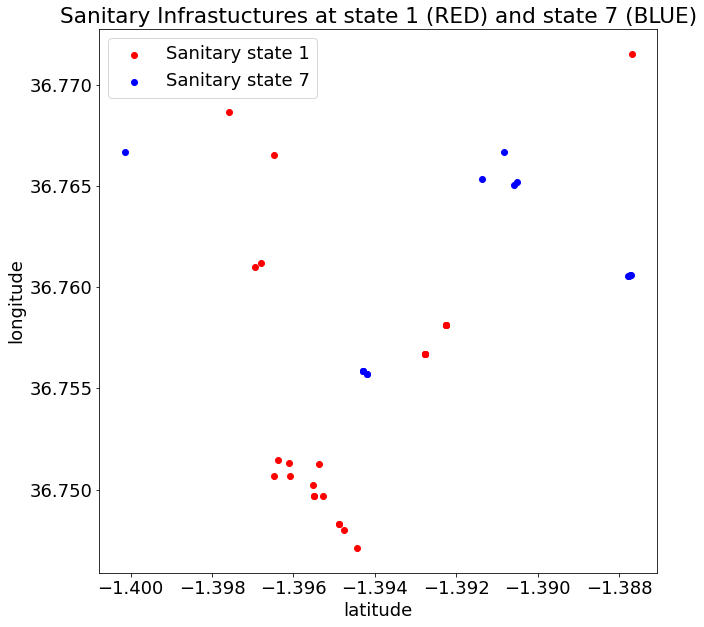

In [1643]:
# Get the indices for level 1 sanitary state at Run off water/sewer line" and "Solid waste site"

sanitary_infrastructure_level1=[]

for i in range(244):
  if(sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==1):
    if(sanitation_data.loc[i,"Type of infrastructure component/features of interest"]=="Run off water/sewer line" or sanitation_data.loc[i,"Type of infrastructure component/features of interest"]=="Solid waste site"): 
      sanitary_infrastructure_level1.append(i)


# Get the indices for level 7 sanitary state at "Water storage tank"
sanitary_infrastructure_level7=[]
for i in range(244):
  if(sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==7):
    if(sanitation_data.loc[i,"Type of infrastructure component/features of interest"]=="Water storage tank"): 
      sanitary_infrastructure_level7.append(i)


level1_coordinates = lat_long_sanitation.loc[sanitary_infrastructure_level1,"latitude":"longitude"].to_numpy()
level7_coordinates = lat_long_sanitation.loc[sanitary_infrastructure_level7,"latitude":"longitude"].to_numpy()


%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})

ax = plt.gca()
P1=ax.scatter(level1_coordinates[:,0], level1_coordinates[:,1], color="r")
P2=ax.scatter(level7_coordinates[:,0], level7_coordinates[:,1], color="b")
ax.legend([P1,P2],["Sanitary state 1","Sanitary state 7"])
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Sanitary Infrastuctures at state 1 (RED) and state 7 (BLUE)")
plt.show()

From the Figure above, it can be seen that the Sanitary Infrastructures with low sanitary state (RED-State 1) mostly occur in clusters geographically. In this case they are clustered in the WEST of the area of interest area (South with respect to the plot. Note the direction of latitudes and longitudes).

On the other hand, Sanitary Infrastructures with high sanitary state (BLUE- State 7) are fewer and less clustered.

======================================================================================================================================================================================================================================

### SECTION 2.2.2: SPATIAL DISTRIBUTION OF LOW AND HIGH SANITARY STATES

While SECTION 2.2.1 focused on the distribution of the least and most sanitary infrastructures, this section will take a look at a wider picture. Here, low sanitary states will be regarded as states 1 and 2. High sanitary states will be regarded as staets 6 and 7. In both cases, the sanitary infrastructures won't be taken into account.

This section is more or less a more general case of SECTION 2.2.2. The following code locates all the states in question and diplay them on a plot.

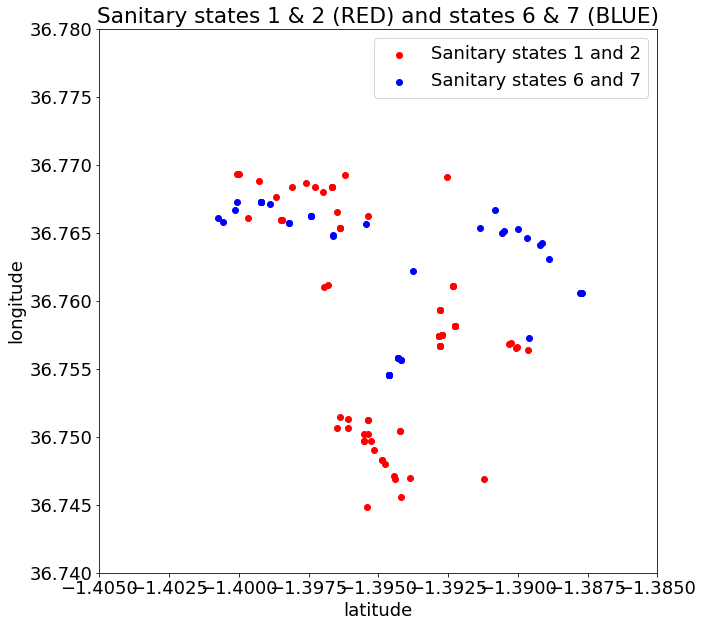

In [1644]:
sanitary_level1_2=[]

for i in range(242):
  if(sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==1 or sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==2):
    sanitary_level1_2.append(i) 

sanitary_level6_7=[]

for i in range(242):
  if(sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==6 or sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==7):
    sanitary_level6_7.append(i)

level1_2_coordinates = lat_long_sanitation.loc[sanitary_level1_2,"latitude":"longitude"].to_numpy()
level6_7_coordinates = lat_long_sanitation.loc[sanitary_level6_7,"latitude":"longitude"].to_numpy()

ax = plt.gca()
P1=ax.scatter(level1_2_coordinates[:,0], level1_2_coordinates[:,1], color="r")
P2=ax.scatter(level6_7_coordinates[:,0], level6_7_coordinates[:,1], color="b")
ax.legend([P1,P2],["Sanitary states 1 and 2","Sanitary states 6 and 7"])
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Sanitary states 1 & 2 (RED) and states 6 & 7 (BLUE)")
plt.ylim((36.74, 36.78))
plt.xlim((-1.405, -1.385))
plt.show()

The above plot shows that the low santary states 1 and 2 appear in more dense clusters with the densest clusters located in the WEST of the target area (South with respect to the plot) and Central-East of the target area. The higher sanitary states are less dense and less numerous.

======================================================================================================================================================================================================================================

### SECTION 2.3: K-MEANS

This section will take  look at how the non-numerical (categorical) information of the dataset can be used to group the data points together.

K-means will be used for clustering as shown in the following code

In [1645]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

categorical = sanitation_data[["Rate the sanitary state of the identified feature","Type of infrastructure component/features of interest","Are water treatment methods observed in the area?"]]

categorical = pd.get_dummies(categorical).to_numpy()

# Standardize the columns
categorical_standardized = (categorical - np.mean(categorical)) / np.std(categorical)

lat_long_sanitation = lat_long_sanitation.to_numpy()

At this point, K-means is ready to start, however, it is good idea to determine the value of K before proceeding with clustering. The following code helps in finding the value of K. The optimum value is found at the **elbow** of the curve

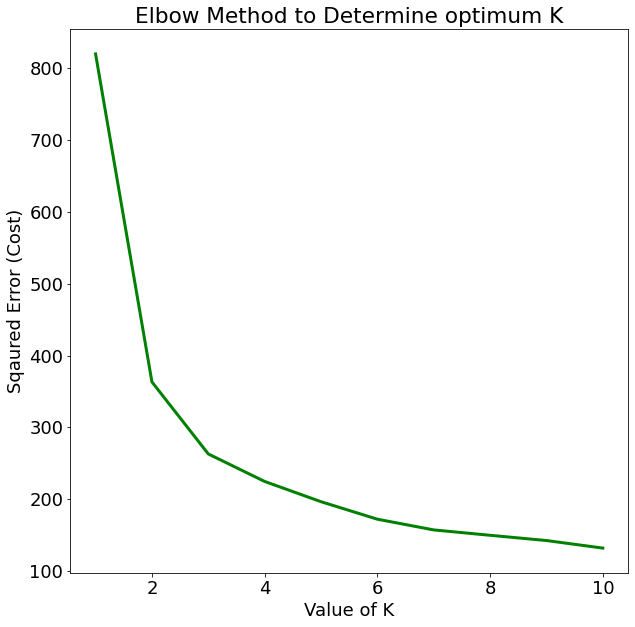

In [1646]:
# Finding the value of K
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(categorical_standardized) # USE STANDARDIZED DATA HERE
      
    # calculates squared error for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.title("Elbow Method to Determine optimum K")
plt.show() 

From the above curve, the elbow is at K=3. The code below will proceed with K-means clustering of the categorical data.

Latitudes and Longitudes of the data points are not used in K-means clustering. They are only used to show the locatiions of the datapoints in the graph.

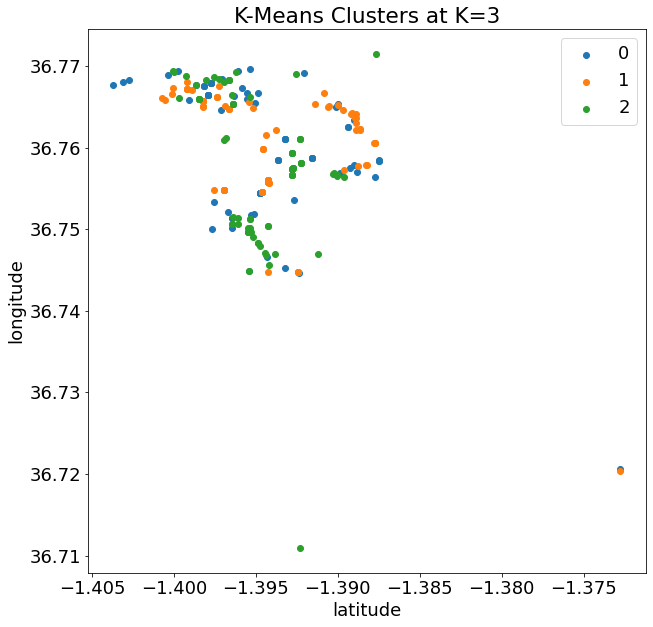

In [1647]:
#####################################################################################
# BEGIN K-MEANS
#####################################################################################
kmeans = KMeans(n_clusters= 3)
label = kmeans.fit_predict(categorical_standardized) 
u_labels = np.unique(label)

fig = plt.figure()
for i in u_labels:
    plt.scatter(lat_long_sanitation[label == i , 0] , lat_long_sanitation[label == i , 1] , label = i) 
plt.legend()
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("K-Means Clusters at K=3")
plt.show()

======================================================================================================================================================================================================================================

# SECTION 3: SUMMARY OF RESULTS AND CONCLUSION

**SECTION 1**  talked about data proparation, formatting and transformation of polar coordinates (latitudes and longitudes) into cartesian coordinates X, and  Y via GEODETIC TO ECEF CONVERSION. This was necessary because polar values don't behave the same way as linear when scalled. This could inturn result in errors during clustering. 

The Section also discussed how using Google's Elevation API, elevations were added to the existing dataset (which originally had latitudes, longitudes, but not altitudes). However, this turned out to not be necessary for this project because only the categorical features were eventually used for clustering.

**SECTION 2** had 3 main parts which are 2.1, 2.2 and 2.3.


SECTION 2.1 was about Gower's Similarity Matrix and how it could be used to determine the most similar data points in the dataset according to their categorical variables. It was shown how the Matrix could be used to determine various datapoints which would be grouped together. Section 2.1 also looked at the relation between sanitary states and the rest of the categorical variables. It was found that run off  / sewage water and Solid waste sites were associated with low sanitary states of 1, especially in areas with open water bodies. On the other hand, areas with higher sanitary states were found to have more water storage tanks and the absence of open water bodies. The type of drinking water could not determine the sanitary state. Last but not least, high sanitary states of 6 and 7 were found where people treated the water, mostly via chlorination.

SECTION 2.2 was about Spatial distribution of infrastructures with least and highest sanitary states. It also looked at the general distribution of sanitary states on the map using the location coordinates.

SECTION 2.3 demonstrated the use of K-means on non-numerical (categorical) variables to determine clusters or groups of connected data points. It was found that the grouping was consistent with the spatial distribution of the various sanitary states in SECTION 2.2

